In [1]:
import pandas as pd

# Databases

## psycopg2 and geopandas

In [3]:
from sqlalchemy import create_engine, text
import geopandas as gpd
import json
import getpass
from urllib.parse import quote_plus
%matplotlib inline

config = json.load(open(f'/home/{getpass.getuser()}/onedrive/config.json'))
db_user = config['db_user']
db_password = quote_plus(config['db_password'])
db_address = config['db_address']
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_address}/gis')

<Axes: >

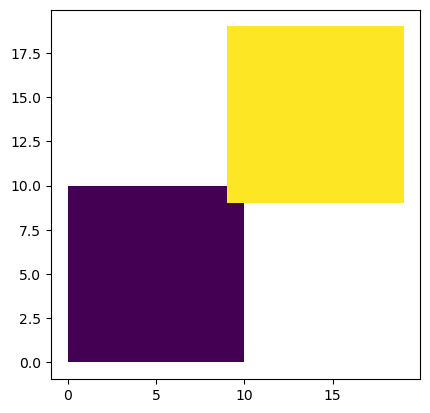

In [4]:
#create polygons
sql = """
    SELECT 
        ST_MakeBox2D(ST_Point(0,0), ST_Point(10,10))::geometry AS geom, 
        1 AS color 
    UNION 
    SELECT 
        ST_MakeBox2D(ST_Point(9,9), ST_Point(19,19))::geometry AS geom, 
        2 AS color
"""
df = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom')
df.plot(column='color')

In [8]:

#saving to postgis
df.set_crs(epsg=27700).to_postgis(
    'polygons', 
    engine, 
    if_exists='replace', 
    schema='miscellaneous',
    index=False
)

#remove polygons
sql = """
    DROP TABLE IF EXISTS miscellaneous.polygons
"""
with engine.connect() as connection:
    result = connection.execute(text(sql))
    connection.commit()


# Dataframes

## creating and editing

In [10]:
#Create a dataframe
d = {"col1" : ['a','b','c','d','e'],
     "col2" : [1,2,3,4,5]}
dataFrame = pd.DataFrame(d)
dataFrame

,col1,col2
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5


In [11]:
#add new row
row = pd.DataFrame({"col1" : ["f"], "col2" : [6]})
dataFrame = pd.concat([dataFrame, row], ignore_index=True)
dataFrame

,col1,col2
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5
5,f,6


In [12]:
#broadcasting a value. At least one column must be a Series or a list, otherwise it requires an index 
#it doesn't matter the position of the list. Could be the first or any other column.

d = {"col1" : ['a','b','c','d','e'],
     "col2" : 1,
     "col3" : "f"}
dataFrame = pd.DataFrame(d)
dataFrame

,col1,col2,col3
0,a,1,f
1,b,1,f
2,c,1,f
3,d,1,f
4,e,1,f


In [13]:
#add new column.
#WARNING: if instead of a list a Series is passed, the assign function will match the indexes, in order words, the 
#series will be sorted. SEE BELOW

d = {"col1" : ['a','b','c','d','e'],
     "col2" : 1,
     "col3" : "f"}
df = pd.DataFrame(d)
df = df.assign(new = [1,2,3,4,5])

df

,col1,col2,col3,new
0,a,1,f,1
1,b,1,f,2
2,c,1,f,3
3,d,1,f,4
4,e,1,f,5


In [18]:
#add new column
d = {"col1" : ['a','b','c','d','e'],
     "col2" : 1,
     "col3" : "f"}
df = pd.DataFrame(d)
df = df.assign(new = pd.Series([1,2,3,4,5], index=[4,3,2,1,0]))
df

,col1,col2,col3,new
0,a,1,f,5
1,b,1,f,4
2,c,1,f,3
3,d,1,f,2
4,e,1,f,1


## grouping

In [24]:
#Group dataframe by col1 and get mean.
grouped = df.groupby('col3')
grouped['col2'].mean()

col3
f    1.0
Name: col2, dtype: float64

In [25]:
# Create a pandas series of 100 timestamps in a period of one hour
timestamps = pd.date_range(start="2023-01-01 00:00:00", periods=100, freq="36S")
series_of_timestamps = pd.Series(timestamps)
series_of_timestamps

/tmp/ipykernel_17054/674821955.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start="2023-01-01 00:00:00", periods=100, freq="36S")


0    2023-01-01 00:00:00
1    2023-01-01 00:00:36
2    2023-01-01 00:01:12
3    2023-01-01 00:01:48
4    2023-01-01 00:02:24
             ...        
95   2023-01-01 00:57:00
96   2023-01-01 00:57:36
97   2023-01-01 00:58:12
98   2023-01-01 00:58:48
99   2023-01-01 00:59:24
Length: 100, dtype: datetime64[ns]

In [26]:
#if a timestamp column is present, you can group by a particular period of time using pd.grouper

import numpy as np
df = pd.DataFrame({
    "date": series_of_timestamps,
    "lat": np.random.uniform(low=-90, high=90, size=100),  # Random latitudes between -90 and 90
    "lon": np.random.uniform(low=-180, high=180, size=100)  # Random longitudes between -180 and 180
})
grouped = df.groupby(["lat", "lon", pd.Grouper(key='date', freq='15min')])
summary = grouped.mean()
summary.head()

,,
lat,lon,date
-89.657583,-96.955128,2023-01-01 00:00:00
-89.555442,-124.629237,2023-01-01 00:30:00
-87.029289,-128.829141,2023-01-01 00:15:00
-85.823300,-127.039895,2023-01-01 00:45:00
-84.758779,-151.312563,2023-01-01 00:45:00


## slicing and selecting

In [27]:
#Create a dataframe
d = {"col1" : ['a','b','c','d','e'],
     "col2" : ['x', 'y', 'y', 'y', 'y'],
     "col3" : [1,1,2,2,4]}
df = pd.DataFrame(d)

#slice by col name
df['col1']

0    a
1    b
2    c
3    d
4    e
Name: col1, dtype: object

In [28]:
#Create a dataframe
d = {"col1" : ['a','b','c','d','e'],
     "col2" : ['x', 'y', 'y', 'y', 'y'],
     "col3" : [1,1,2,2,4]}
df = pd.DataFrame(d)

#slice by position
df.iloc[2]

col1    c
col2    y
col3    2
Name: 2, dtype: object

In [29]:
#Create a dataframe
d = {"col1" : ['a','b','c','d','e'],
     "col2" : ['x', 'y', 'y', 'y', 'y'],
     "col3" : [1,1,2,2,4]}
df = pd.DataFrame(d, index = ['first', 'second', 'third', 'fourth', 'fifth'])

#slice by row name
df.loc['fifth']

col1    e
col2    y
col3    4
Name: fifth, dtype: object

In [30]:
#find location of column by name
df.columns.get_loc("col1")

0